<center>
    <h1><b>Deep Learning for Natural Language Processing<b></h1>
</center>

In this notebook we will develop a **sentiment classifier** on a given English-language **Twitter Dataset** containing some user comments. The main goal is to build a model that understands whether a specific comment has a **positive** sentiment or a **negative** sentiment.

## Data Preprocessing and Analysis

We will  begin by importing the **dataset** we are going to work with. The provided dataset consists of **3 CSV files** each one having its significant role in the process. We have the **training**, **validating** and **testing** files.
1. The training file is going to be used to train our model.
2. The validating file will tell us how good our model is by computing its accuracy.
3. The testing file is going to be used to test our model and extract some results and statistics.

Let's load our dataset files that are located in the `/Data/` directory.

In [37]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

dataset_base_filepath = '../Data/Raw' # "/kaggle/input/ai-2-deep-learning-for-nlp-homework-1"
images_base_filepath = '../imgs' # "/kaggle/input/images"

# Load all the dataset files using pandas and store inside some dataframe variables
train_df = pd.read_csv(f'{dataset_base_filepath}/train_dataset.csv')
val_df = pd.read_csv(f'{dataset_base_filepath}/val_dataset.csv')
test_df = pd.read_csv(f'{dataset_base_filepath}/test_dataset.csv')

# Reduce the data sizes
size=1
train_df = train_df.sample(frac=size)
val_df = val_df.sample(frac=size)
# test_df = test_df.sample(frac=size)

print(train_df.shape, val_df.shape, test_df.shape)

(148388, 3) (42396, 3) (21199, 2)


Let's take a look at some of the records of the training dataset.

In [38]:
train_df.head()

,ID,Text,Label
87798,99828,New yellow cardigan. I may never take it off.,1
21053,1392,"@ashhh_x wow, i'm actually pretty happy, going...",1
23084,143994,is fairly certain her ipod was stolen out of h...,0
71702,195099,@dannywood HMM Gonna go with ran 4 miles and h...,1
85579,61083,@TotusMel I still need to learn HOW to do spli...,0


### Data sizes

Let's have a look at the **sizes** of these datasets. In machine learning a **suitable size** of training, validating and testing data is around 70%, 20% and 10% respectively. 

Training Dataset size: 148388
Validating Dataset size: 42396
Testing Dataset size: 21199


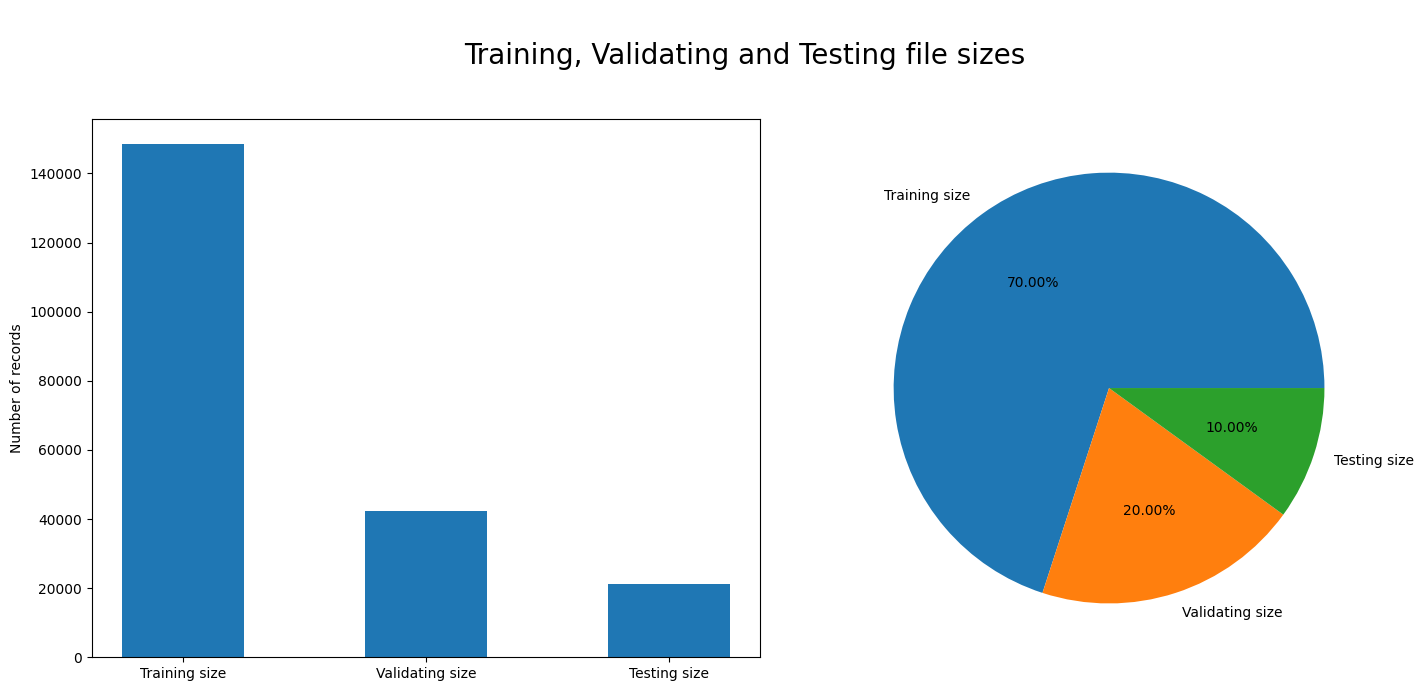

In [39]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

colors=['#99CCFF', '#C0DCFF', '#DAEDFF']

# Get the number of records for each dataset
train_size = train_df.shape[0]
val_size = val_df.shape[0]
test_size = test_df.shape[0]

print(f"Training Dataset size: {train_size}")
print(f"Validating Dataset size: {val_size}")
print(f"Testing Dataset size: {test_size}")

sizes = [train_size, val_size, test_size]
labels = ["Training size", "Validating size", "Testing size"]

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes[0].bar(labels, sizes, width=0.5)
axes[0].set_ylabel("Number of records")

axes[1].pie(sizes, labels=labels, autopct="%1.2f%%")

plt.suptitle("\nTraining, Validating and Testing file sizes\n", fontsize=20)
plt.tight_layout()
plt.show()

From the results above we can easily tell that our dataset files satisfy the data splitting criterion.

### Processing and Cleaning

The first step of the whole process is to **pre-process** and **clean** our dataset files. In Machine Learning and AI applications, this is the initial and really important step. We will focus on
1. Transform shortcuts like **"I'm" to "I am"**.
2. Removing **URLs**, **User mentions**, **Hashtags** and **special characters**.
3. **Lowercasing** the texts
4. Removing **extra spaces**
5. Applying **stemming** and **lemmatization**

Let's begin by implementing a **function** that will handle the data pre-processing for a given string.

In [40]:
import os
import re
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
import contractions

nltk.download('wordnet')
nltk.download('omw-1.4')

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text: str) -> str:
    text = text.lower() # Convert to lowercase
    text = contractions.fix(text) # Expand contractions
    text = re.sub(r"http\S+|www\S+|https\S+", "", text) # Remove url links
    text = re.sub(r"@\w+", "", text) # Remove mentions
    text = re.sub(r"#(\w+)", "", text) # Remove hastags
    text = re.sub(r"(?<!\.)\.(?!\.)|[^\w\s\?\!]", "", text)
    text = re.sub(r"\.\.\.", " ... ", text)  # Ensure '...' is treated as a single token
    
    text = re.sub(r"&[^;\s]+;", "", text) # Remove special characters
    text = re.sub(r"\s+", " ", text) # Remove extra spaces
    
    text = re.sub(r"\d+", "", text)
    
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words] # Apply stemming
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words] # Apply lemmatization
    text = " ".join(lemmatized_words)
    
    return text

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Antonis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Antonis\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Let's apply this function to the 3 dataset files, and see the results.

In [41]:
import time

# Apply the cleaning function to every dataset file and create a new column with the modified text
start_time = time.time()
train_df["Cleaned_text"] = train_df["Text"].apply(clean_text)
val_df["Cleaned_text"] = val_df["Text"].apply(clean_text)
test_df["Cleaned_text"] = test_df["Text"].apply(clean_text)
end_time = time.time()

print(f"Datasets were cleaned in {end_time - start_time} seconds.")

train_df.head(10)

Datasets were cleaned in 42.43702220916748 seconds.


,ID,Text,Label,Cleaned_text
87798,99828,New yellow cardigan. I may never take it off.,1,new yellow cardigan i may never take it off
21053,1392,"@ashhh_x wow, i'm actually pretty happy, going...",1,wow i am actual pretti happi go to the show of...
23084,143994,is fairly certain her ipod was stolen out of h...,0,is fairli certain her ipod wa stolen out of he...
71702,195099,@dannywood HMM Gonna go with ran 4 miles and h...,1,hmm go to go with ran mile and hit the gym now...
85579,61083,@TotusMel I still need to learn HOW to do spli...,0,i still need to learn how to do split ringsso ...
125308,120644,is tabbing out and going home to fix her compu...,0,is tab out and go home to fix her comput
24793,155058,I can't modify a frozen hash,0,i cannot modifi a frozen hash
47910,63832,Today: Merrick Park w/ Ana,1,today merrick park w ana
81951,105984,@mmitchelldaviss http://twitpic.com/6i5xs - Wo...,1,wow that is complic yet it is beautiful!
72270,78751,yogurtland study breaks are always good. and ...,0,yogurtland studi break are alway good and yet ...


We will now proceed to **analyze** the **training dataset**. We are going to focus on the **words** of each tweet and extract the most frequent ones, by generating a **Word Cloud** and a **Bar Plot**.

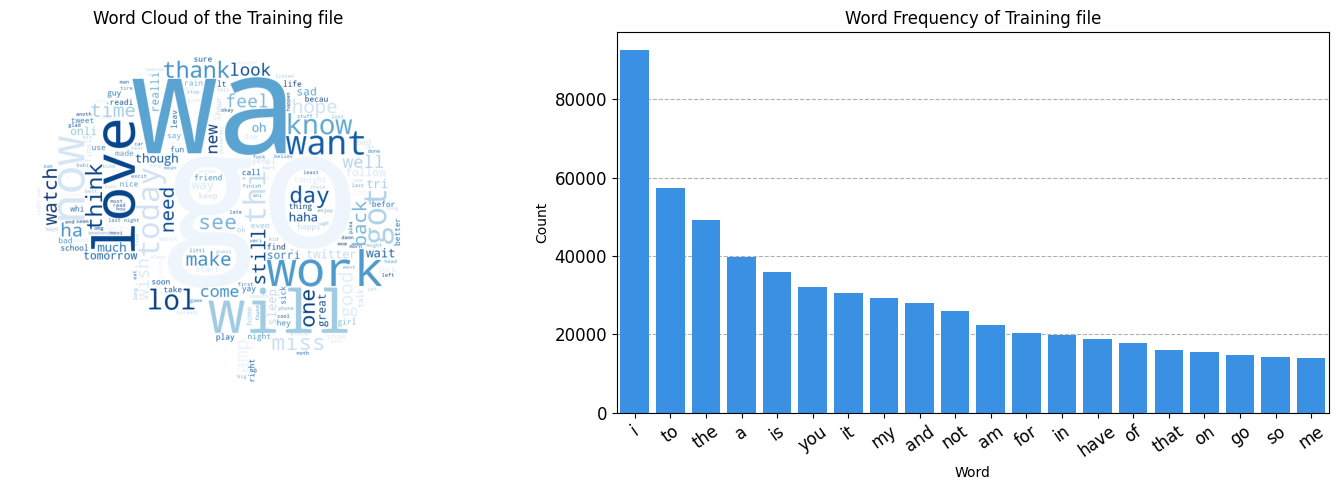

In [42]:
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
import numpy as np
import PIL.Image

brain_mask = np.array(PIL.Image.open(images_base_filepath + "/brain_logo.jpg"))

def analize_words(df: pd.DataFrame, column: str, bar_color="#7AC2FF"):
    all_text = " ".join(df[column])
    all_words = " ".join(df[column]).split()
    
    word_counts = Counter(all_words)
    most_common_words = word_counts.most_common(20)
    
    common_df = pd.DataFrame(most_common_words, columns=["Word", "Count"])
    
    wordcloud = WordCloud(width=800, height=800, background_color="#FFF", colormap="Blues", mask=brain_mask)
    wordcloud.generate(all_text)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].imshow(wordcloud)
    axes[0].axis("off")
    axes[0].set_title("Word Cloud of the Training file")
    
    axes[1].set_axisbelow(True)
    axes[1].grid(zorder=1, linestyle='dashed')
    bars = sns.barplot(x="Word", y="Count", data=common_df, color=bar_color, ax=axes[1])
    
    axes[1].set_title("Word Frequency of Training file")
    axes[1].set_xticklabels(labels=common_df["Word"], rotation=35, fontsize=10)
    axes[1].tick_params(axis="both", which="major", labelsize=12)
    
    # plt.savefig(filename)
    plt.tight_layout()
    plt.show()

analize_words(train_df, column='Cleaned_text', bar_color='dodgerblue')

The above graphs reveal to us the frequency of some words inside the dataset. The plot on the right appears to have words that are not practically useful. These words are called **stopwords** and the `wordcloud` Python package automatically ignores them. That's because we have different results on the left and right plots. Having stopwords in our dataset is not a good practice for sentiment analysis because stopwords do not add much meaning. So we will take care of them by removing them from the dataset.

In [43]:
import nltk
from nltk import data
from nltk.tokenize import word_tokenize
import time

warnings.filterwarnings("ignore", category=UserWarning, module="nltk")

def remove_stopwords(text: str) -> str:
    # Remove the stopwords from the original text
    stop_words = set(
        ["i", "to", "the", "is", "a", "you", "my", "and", 
         "it", "am", "for", "in", "of", "that", "on", "so", "me"]
    )
    word_tokens = word_tokenize(text)
    filtered_words = [word for word in word_tokens if word not in stop_words]

    return " ".join(filtered_words)

start_time = time.time()
train_df['Cleaned_text'] = train_df['Cleaned_text'].apply(remove_stopwords)
val_df['Cleaned_text'] = val_df['Cleaned_text'].apply(remove_stopwords)
test_df['Cleaned_text'] = test_df['Cleaned_text'].apply(remove_stopwords)
end_time = time.time()


print(f"Stopwords were removed in {end_time - start_time} seconds.")

Stopwords were removed in 18.310641288757324 seconds.


By executing the code above we must have removed some useless stopwords from the dataset. Let's have a look at the dataset and the analytics one more time.

In [44]:
train_df.head(10)

,ID,Text,Label,Cleaned_text
87798,99828,New yellow cardigan. I may never take it off.,1,new yellow cardigan may never take off
21053,1392,"@ashhh_x wow, i'm actually pretty happy, going...",1,wow actual pretti happi go show life next week...
23084,143994,is fairly certain her ipod was stolen out of h...,0,fairli certain her ipod wa stolen out her car ...
71702,195099,@dannywood HMM Gonna go with ran 4 miles and h...,1,hmm go go with ran mile hit gym now time wake ...
85579,61083,@TotusMel I still need to learn HOW to do spli...,0,still need learn how do split ringsso mani pat...
125308,120644,is tabbing out and going home to fix her compu...,0,tab out go home fix her comput
24793,155058,I can't modify a frozen hash,0,can not modifi frozen hash
47910,63832,Today: Merrick Park w/ Ana,1,today merrick park w ana
81951,105984,@mmitchelldaviss http://twitpic.com/6i5xs - Wo...,1,wow complic yet beautiful !
72270,78751,yogurtland study breaks are always good. and ...,0,yogurtland studi break are alway good yet stil...


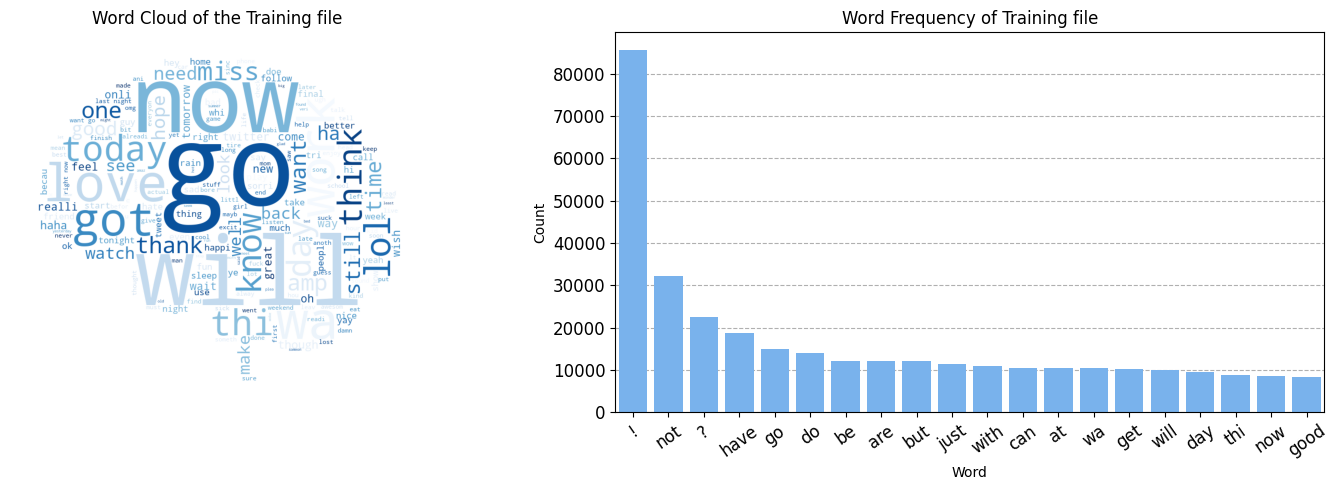

In [45]:
analize_words(train_df, column='Cleaned_text', bar_color="#66B2FF")

As we expected all the common stopwords like 'I', 'the', 'so' and more have been deleted from the records of the dataset. As we can see the dataset has been cleaned successfully and there not any stopwords in the records.

### Exploratory Data Analysis (EDA)

We are now going to fall into a deeper analysis of the dataset, in order to collect some information about the user comments.

### Text Length Analysis
We will start by analizing the **length** of the tweets in both training and validation files. Specifically will perform a **Tweet Length Distribution** and a **Comparison between sentiments**. 

#### Tweet Length DIstribution

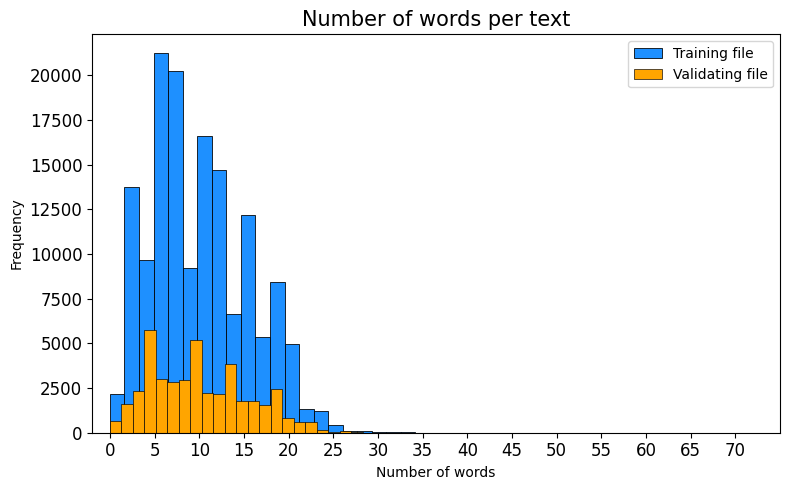

In [46]:
import seaborn as sns


train_df['num_words'] = train_df['Cleaned_text'].apply(lambda x: len(x.split()))
val_df['num_words'] = val_df['Cleaned_text'].apply(lambda x: len(x.split()))

# Plot the histogram of the number of words in the training and validating files
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(train_df['num_words'], bins=70, color='dodgerblue', label='Training file', ax=ax, alpha=1)
sns.histplot(val_df['num_words'], bins=70, color='orange', label='Validating file', ax=ax, alpha=1)

ax.set_xlabel("Number of words")
ax.set_ylabel("Frequency")
ax.legend()

ax.set_xlim(-2, 75)
ax.set_xticks(range(0, 75, 5))
ax.tick_params(axis='both', which='major', labelsize=12)

plt.title("Number of words per text", fontsize=15)
plt.tight_layout()
plt.show()


#### Comparison between Sentiment

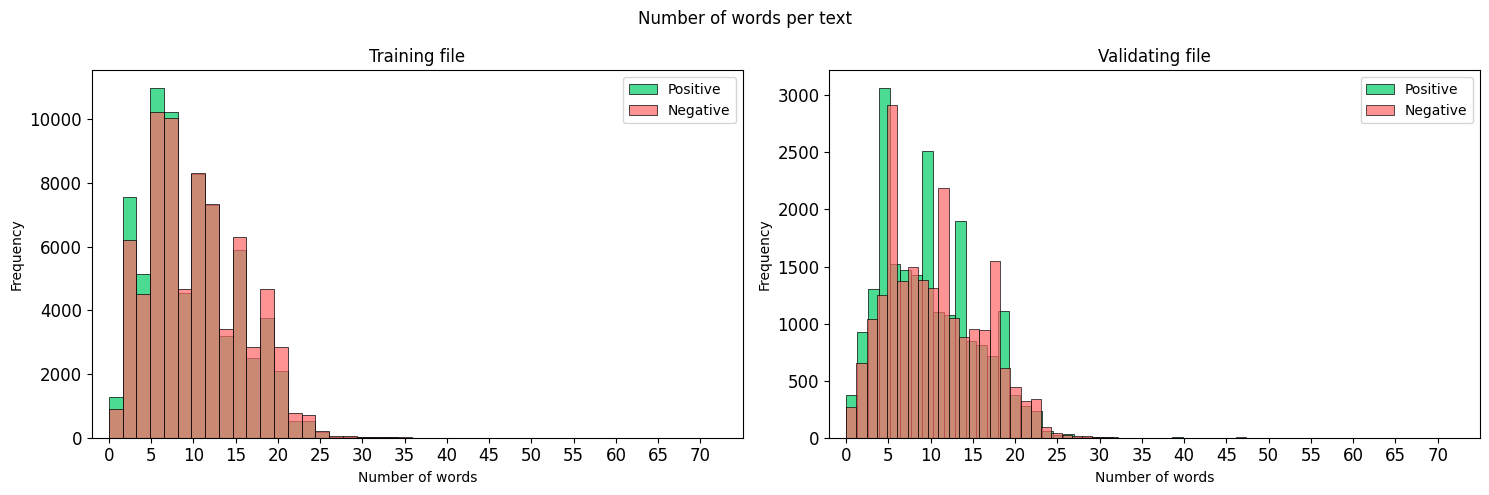

In [47]:
# Compare words frequency between positive and negative tweets
positive_train_df = train_df[train_df['Label'] == 1]
negative_train_df = train_df[train_df['Label'] == 0]

positive_val_df = val_df[val_df['Label'] == 1]
negative_val_df = val_df[val_df['Label'] == 0]

# Plot the word frequency of positive and negative tweets for the training and validating files
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(positive_train_df['num_words'], bins=70, color='#00CC66', label='Positive', ax=axes[0], alpha=0.7)
sns.histplot(negative_train_df['num_words'], bins=70, color='#FF6666', label='Negative', ax=axes[0], alpha=0.7)

sns.histplot(positive_val_df['num_words'], bins=70, color='#00CC66', label='Positive', ax=axes[1], alpha=0.7)
sns.histplot(negative_val_df['num_words'], bins=70, color='#FF6666', label='Negative', ax=axes[1], alpha=0.7)

axes[0].set_title("Training file")
axes[1].set_title("Validating file")

for ax in axes:
    ax.set_xlabel("Number of words")
    ax.set_ylabel("Frequency")
    ax.legend()
    ax.set_xlim(-2, 75)
    ax.set_xticks(range(0, 75, 5))
    ax.tick_params(axis='both', which='major', labelsize=12)
    
plt.suptitle("Number of words per text")
plt.tight_layout()
plt.show()

### Sentiment Distribution Analysis

Then we will attempt to do a **sentiment distribution analsysis** to training and validating dataset files. Specifically we will count the number of tweets for each sentiment in both training and validating files.

In [48]:
def get_sentiment_distribution(df: pd.DataFrame) -> tuple[int, int]:
    positive_count, negative_count = 0, 0
    for label in df['Label']:
        if label == 1: positive_count += 1
        else: negative_count += 1

    return positive_count, negative_count

Training file has 74196 positive tweets and 74192 negative tweets
Validating file has 21199 positive tweets and 21197 negative tweets


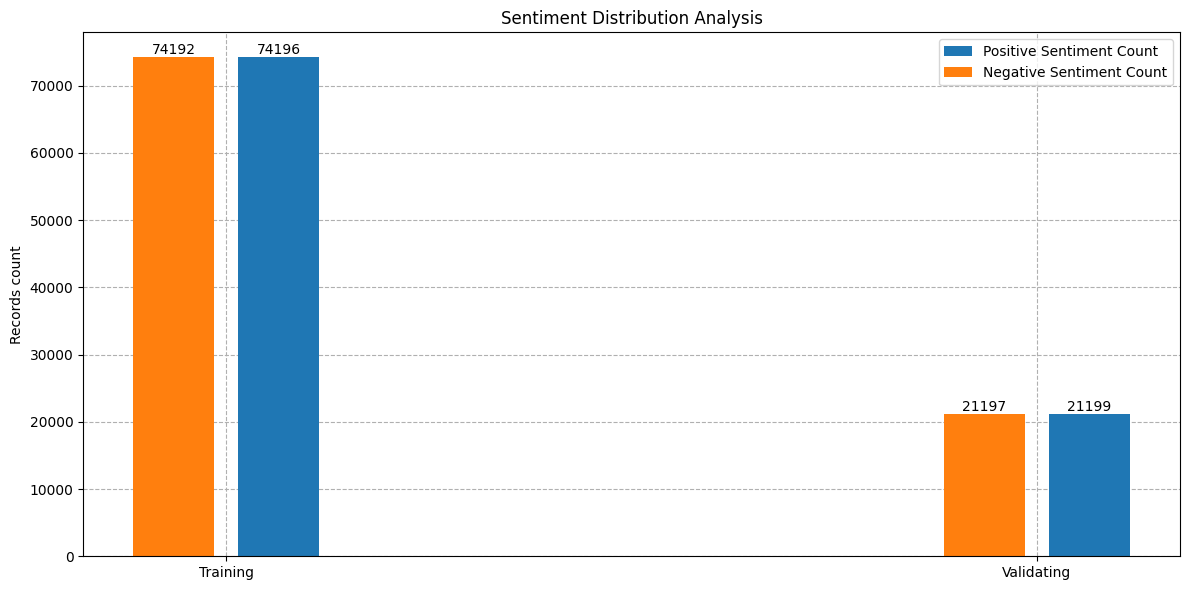

In [49]:
import numpy as np

# Get the sentiment distribution analysis of training and validating files
train_sent_dist = get_sentiment_distribution(train_df)
val_sent_dist = get_sentiment_distribution(val_df)

print(f"Training file has {train_sent_dist[0]} positive tweets and {train_sent_dist[1]} negative tweets")
print(f"Validating file has {val_sent_dist[0]} positive tweets and {val_sent_dist[1]} negative tweets")

files_labels = ["Training", "Validating"]

bar_width = 0.10
gap = 0.015

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set_axisbelow(True)
ax.grid(zorder=1, linestyle='dashed')
positive_bar = ax.bar(
    np.arange(len(files_labels)) + bar_width/2+gap, 
    [train_sent_dist[0], val_sent_dist[0]], 
    width=bar_width, 
    label='Positive Sentiment Count'
)

negative_bar = ax.bar(
    np.arange(len(files_labels)) - bar_width/2-gap, 
    [train_sent_dist[1], val_sent_dist[1]], 
    width=bar_width, 
    label='Negative Sentiment Count'
)

ax.bar_label(positive_bar, label_type='edge')
ax.bar_label(negative_bar, label_type='edge')

ax.set_title('Sentiment Distribution Analysis')
ax.set_ylabel('Records count')

ax.set_xticks(np.arange(len(files_labels)))
ax.set_xticklabels(files_labels)

plt.legend()
plt.tight_layout()

# plt.savefig('../plots/dataset_sentiment_distribution.png')
plt.show()

As we can see the number of positive and negative tweets inside the training and validating dataset files are **almost equal**. In both files the positive tweets prevail over the negative ones. Generally we can say that the dataset is **balanced**.

### Generalized diagram

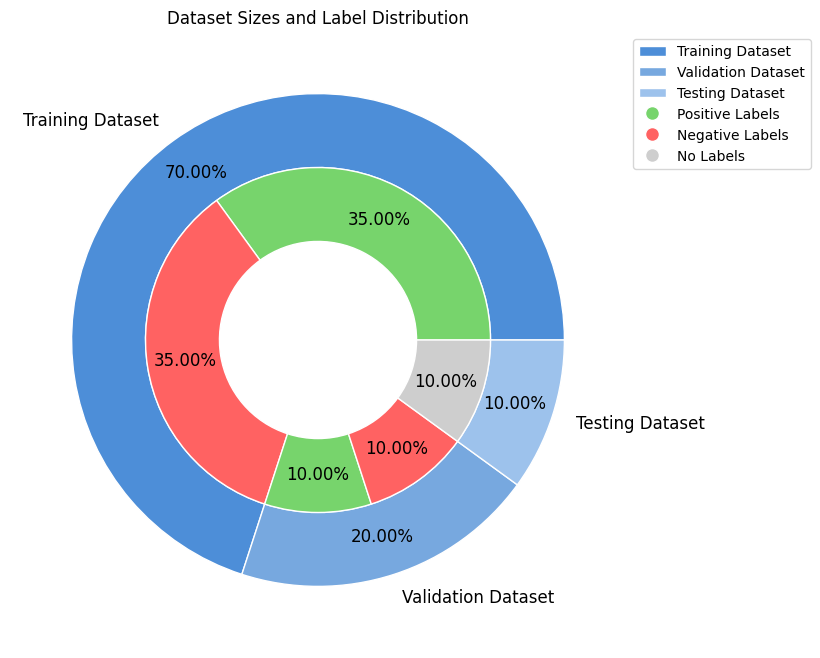

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Dataset names
datasets = ['Training Dataset', 'Validation Dataset', 'Testing Dataset']

# Total dataset sizes
total_sizes = np.array([train_df.shape[0], val_df.shape[0], test_df.shape[0]])

# Positive and Negative label counts (for Training and Validation datasets)
pos_counts = np.array(
    [train_df[train_df['Label'] == 1].shape[0], 
     val_df[val_df['Label'] == 1].shape[0], 0]
)

neg_counts = np.array(
    [train_df[train_df['Label'] == 0].shape[0], 
     val_df[val_df['Label'] == 0].shape[0], 0]
) 

# Define outer ring (total dataset sizes)
outer_sizes = total_sizes
outer_labels = datasets
outer_colors = ['#4D8ED8', '#77A8DF', '#9DC2EC']

# Define inner ring (label distribution)
inner_sizes = []
inner_colors = []
legend_labels = []  # Used for a separate legend

for i in range(len(datasets)):
    if pos_counts[i] > 0 or neg_counts[i] > 0:
        inner_sizes.extend([pos_counts[i], neg_counts[i]])
        inner_colors.extend(["#77D46C", "#FF6262"])  # Green for positive, red for negative
    else:
        inner_sizes.append(total_sizes[i])  # No labels
        inner_colors.append("#CECECE")  # Gray for unlabeled data

fig, ax = plt.subplots(figsize=(8, 8))

# Function to manually compute and display correct percentages
def correct_autopct(pct, values):
    absolute = int(round(pct / 100. * np.sum(values)))  # Convert percent to actual count
    true_pct = absolute / np.sum(values) * 100  # Compute correct percentage
    return f"{true_pct:.2f}%" if absolute > 0 else ""  # Hide zero values

# Outer pie (Total dataset sizes) with percentages
outer_patches, outer_texts, outer_autotexts = ax.pie(
    outer_sizes, labels=outer_labels, colors=outer_colors, radius=1, 
    wedgeprops=dict(width=0.3, edgecolor='w'), autopct=lambda pct: correct_autopct(pct, outer_sizes), 
    textprops={'fontsize': 12}
)

# Inner pie (Label distribution) with percentages
inner_patches, inner_texts, inner_autotexts = ax.pie(
    inner_sizes, colors=inner_colors, radius=0.7,
    wedgeprops=dict(width=0.3, edgecolor='w'), autopct=lambda pct: correct_autopct(pct, inner_sizes), 
    textprops={'fontsize': 12}
)

# Adjust the percentage label positions to move them slightly outward
for autotext in outer_autotexts:
    x, y = autotext.get_position()
    autotext.set_position((x * 1.4, y * 1.4))  # Move outward

for autotext in inner_autotexts:
    x, y = autotext.get_position()
    autotext.set_position((x * 1.3, y * 1.3))  # Move further outward for inner pie

# Create legend manually (only unique "Positive" and "Negative" labels)
legend_patches = outer_patches  # Only dataset labels initially
legend_labels = outer_labels  # Only dataset names initially

# Add a single entry for "Positive" and "Negative"
positive_patch = plt.Line2D(
    [0], [0], marker='o', color='w', markersize=10, 
    markerfacecolor='#77D46C', label="Positive Labels"
)
negative_patch = plt.Line2D(
    [0], [0], marker='o', color='w', markersize=10, 
    markerfacecolor='#FF6262', label="Negative Labels"
)
no_label_patch = plt.Line2D(
    [0], [0], marker='o', color='w', markersize=10, 
    markerfacecolor='#CECECE', label="No Labels"
)

# Extend the legend with "Positive" and "Negative" colors
legend_patches.extend([positive_patch, negative_patch, no_label_patch])
legend_labels.extend(["Positive Labels", "Negative Labels", "No Labels"])

ax.legend(handles=legend_patches, labels=legend_labels, loc="upper left", bbox_to_anchor=(1, 1))

# Title
plt.title("Dataset Sizes and Label Distribution")
plt.show()


### Sentiment Correlation

Finally we will do some **sentiment correlation** with **specific words**. In other words we will identify the words that are highly correlated with a specific sentiment. Let's begin by splitting the training dataset into two data frames containing all the positive and negative tweets.

In [51]:
train_positive_df = train_df[train_df['Label'] == 1]
train_negative_df = train_df[train_df['Label'] == 0]

In [52]:
train_positive_df.head()

,ID,Text,Label,Cleaned_text,num_words
87798,99828,New yellow cardigan. I may never take it off.,1,new yellow cardigan may never take off,7
21053,1392,"@ashhh_x wow, i'm actually pretty happy, going...",1,wow actual pretti happi go show life next week...,14
71702,195099,@dannywood HMM Gonna go with ran 4 miles and h...,1,hmm go go with ran mile hit gym now time wake ...,13
47910,63832,Today: Merrick Park w/ Ana,1,today merrick park w ana,5
81951,105984,@mmitchelldaviss http://twitpic.com/6i5xs - Wo...,1,wow complic yet beautiful !,5


In [53]:
train_negative_df.head()

,ID,Text,Label,Cleaned_text,num_words
23084,143994,is fairly certain her ipod was stolen out of h...,0,fairli certain her ipod wa stolen out her car ...,13
85579,61083,@TotusMel I still need to learn HOW to do spli...,0,still need learn how do split ringsso mani pat...,11
125308,120644,is tabbing out and going home to fix her compu...,0,tab out go home fix her comput,7
24793,155058,I can't modify a frozen hash,0,can not modifi frozen hash,5
72270,78751,yogurtland study breaks are always good. and ...,0,yogurtland studi break are alway good yet stil...,13


Let's find and plot the **30 most common** words in each data frame.

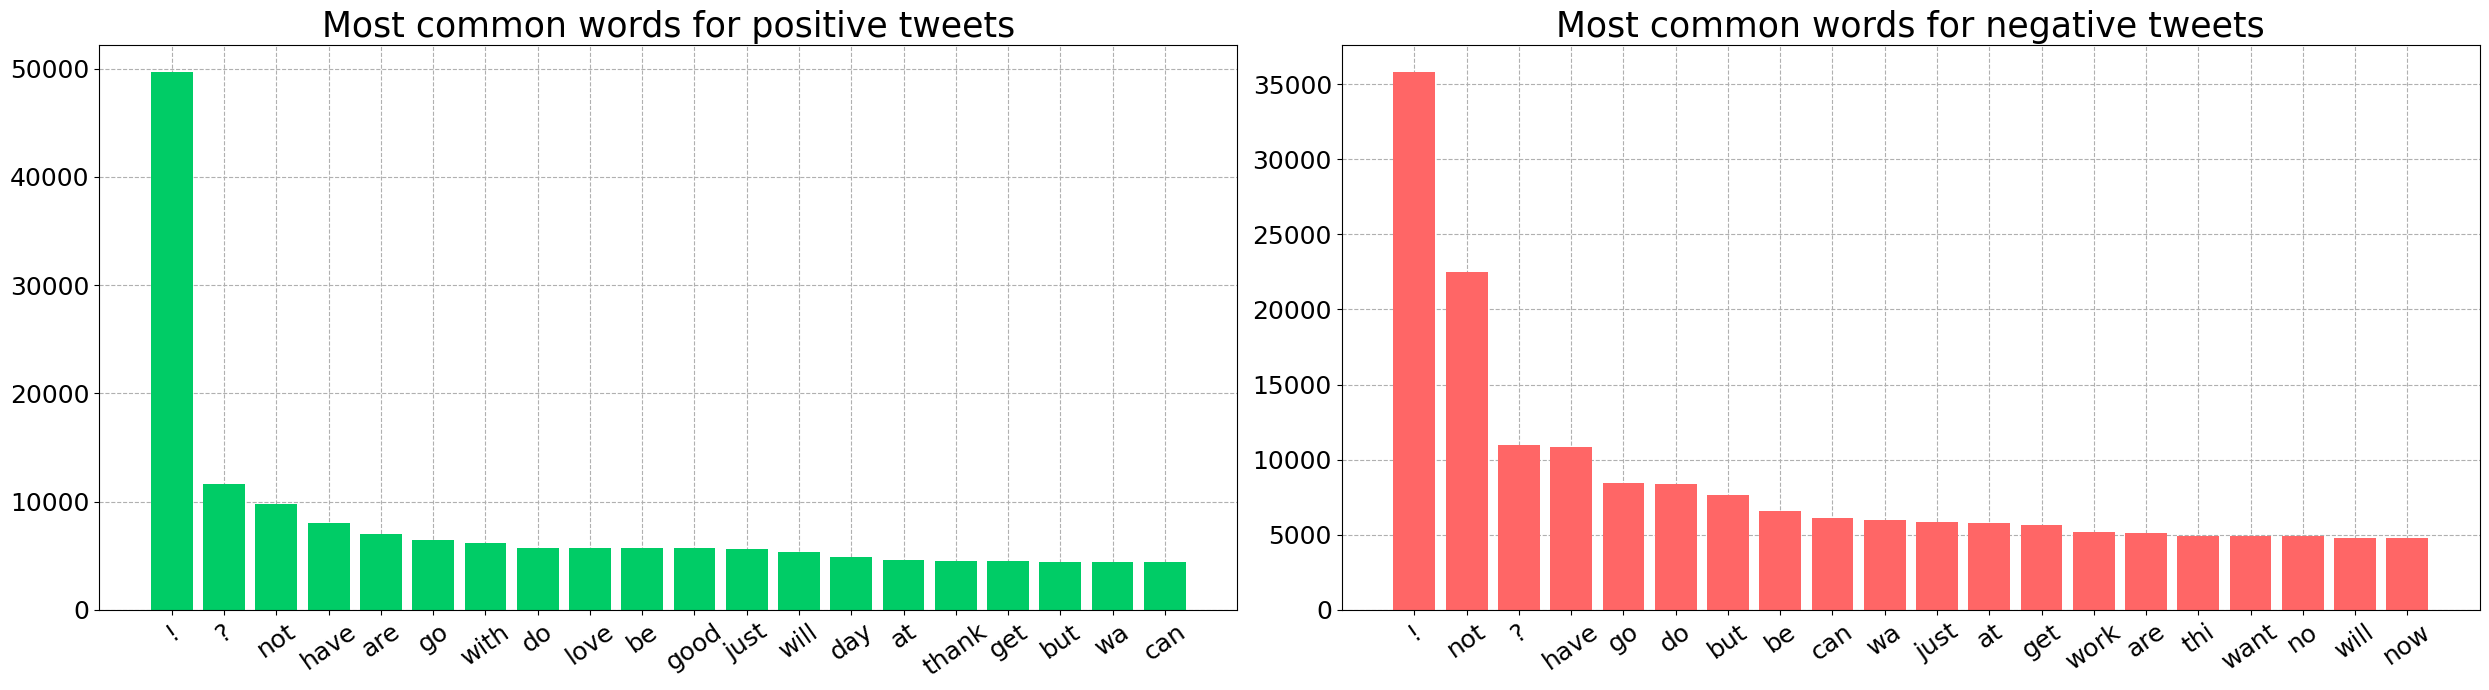

In [54]:
from collections import Counter

# Receive all the words from the positive dataframe
all_train_positive_text = " ".join(train_positive_df['Cleaned_text'])
all_train_positive_words = all_train_positive_text.split()

# Find the most common words
train_positive_words_counter = Counter(all_train_positive_words)
most_common_train_positive_words = train_positive_words_counter.most_common(20)

# Receive all the words from the negative dataframe
all_train_negative_text = " ".join(train_negative_df['Cleaned_text'])
all_train_negative_words = all_train_negative_text.split()

# Find the most common words
train_negative_words_counter = Counter(all_train_negative_words)
most_common_train_negative_words = train_negative_words_counter.most_common(20)

# Plot the data
positive_labels = [word[0] for word in most_common_train_positive_words]
positive_count = [word[1] for word in most_common_train_positive_words]

negative_labels = [word[0] for word in most_common_train_negative_words]
negative_count = [word[1] for word in most_common_train_negative_words]

fig, axes = plt.subplots(1, 2, figsize=(25, 7))
axes[0].set_axisbelow(True)
axes[0].grid(zorder=1, linestyle='dashed')
axes[0].bar(positive_labels, positive_count, color="#00CC66")
axes[0].set_title('Most common words for positive tweets', fontsize=25)
axes[0].set_xticklabels(labels=positive_labels, rotation=35, fontsize=15)
axes[0].tick_params(axis='both', which='major', labelsize=18)

axes[1].set_axisbelow(True)
axes[1].grid(zorder=1, linestyle='dashed')
axes[1].bar(negative_labels, negative_count, color="#FF6666")
axes[1].set_title('Most common words for negative tweets', fontsize=25)
axes[1].set_xticklabels(labels=negative_labels, rotation=35, fontsize=15)
axes[1].tick_params(axis='both', which='major', labelsize=18)

# plt.savefig('../plots/most_common_words.png')
plt.tight_layout()
plt.show()

## Model Training and Evaluation

We will now perform the **training process** of the model. We will start by initializing the **TF-IDF** vectorizer.

In [55]:
train_df

,ID,Text,Label,Cleaned_text,num_words
87798,99828,New yellow cardigan. I may never take it off.,1,new yellow cardigan may never take off,7
21053,1392,"@ashhh_x wow, i'm actually pretty happy, going...",1,wow actual pretti happi go show life next week...,14
23084,143994,is fairly certain her ipod was stolen out of h...,0,fairli certain her ipod wa stolen out her car ...,13
71702,195099,@dannywood HMM Gonna go with ran 4 miles and h...,1,hmm go go with ran mile hit gym now time wake ...,13
85579,61083,@TotusMel I still need to learn HOW to do spli...,0,still need learn how do split ringsso mani pat...,11
...,...,...,...,...,...
96718,88043,http://twitpic.com/6f8ke - Cutest kitten award...,1,cutest kitten award goe teddi,5
39403,101666,@DaveMatthewsB New album is fantastic! See you...,1,new album fantastic ! see london can not wait !,10
146939,193913,"- aw, just missed Kim Possible...",0,aw just miss kim possibl,5
74546,143251,"@PerryBelcher Oh, no way! I hope you bought t...",0,oh no way ! hope bought insur,7


### Vectorizing the data
We will start by **vectorizing** our data. We will define a function where it's going to take the **maximum features** and the **range of the ngrams**. In this way we can later execute some experiments with different values of these parameters.

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_data(train_df, val_df, test_df, max_features=100000, ngram_range=(1,4)):
    if max_features is None and ngram_range is None:
        vectorizer = TfidfVectorizer()
    else:
        vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=ngram_range
        )

    X_train = vectorizer.fit_transform(train_df['Cleaned_text'])
    X_val = vectorizer.transform(val_df['Cleaned_text'])
    X_test = vectorizer.transform(test_df['Cleaned_text'])
    
    y_train = train_df['Label']
    y_val = val_df['Label']

    return X_train, X_val, X_test, y_train, y_val, vectorizer

Let's try to vectorize our data with the **default parameters** at first.

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Load the data and vectorize them using TF-IDF method
X_train, X_val, X_test, y_train, y_val, vectorizer = vectorize_data(train_df, val_df, test_df, None, None)
print(X_train.shape, X_val.shape)

(148388, 72713) (42396, 72713)


Our result matrices are $148388 \times 72713$, and $42396 \times 72713$ individualy, on which the rows represent the documents and the columns represent the words.

### Default Prediction
We will start by executing a default (dummy) prediction on our **validation data** without having a trained model.

In [59]:
batch_size = 1000  

weights, bias = np.random.randn(X_val.shape[1], 1), np.random.randn()
y_pred = np.zeros((X_val.shape[0], 1))  # Placeholder for predictions

# Use batches for faster calculation
for i in range(0, X_val.shape[0], batch_size):
    batch_end = i + batch_size
    y_pred[i:batch_end] = X_val[i:batch_end] @ weights + bias

y_pred = np.where(y_pred >= 0.5, 1, 0)
accuracy = accuracy_score(y_val, y_pred)
print(f"Default Accuracy: {accuracy}")

Default Accuracy: 0.49830172657797905


As we can see a random default prediction gives an **accuracy** of about **0.5**. That is logical to happen due to the fact that the datasets are **balanced** as we saw previously.

### Base Model

#### Logistic Regression Definition
We will continue by creating the model on which the training procedure will be done. This of course is based on the **Logistic Regression**. We will also train our model using the train file.

In [60]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [61]:
# Predict the validation data and calculate the evaluation metrics and classification report
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

# Create a dataframe of the classification report
report_df = pd.DataFrame(classification_report(y_val, y_pred, output_dict=True)).T

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
report_df

Accuracy: 0.7819841494480612
Precision: 0.7775559476274492
Recall: 0.7899900938723524
F1 Score: 0.7837237054542902


,precision,recall,f1-score,support
0,0.786557,0.773977,0.780216,21197.000000
1,0.777556,0.789990,0.783724,21199.000000
accuracy,0.781984,0.781984,0.781984,0.781984
macro avg,0.782056,0.781984,0.781970,42396.000000
weighted avg,0.782056,0.781984,0.781970,42396.000000


#### Confusion Matrix
Let's compute and visualize the **confusion matrix** of the base model.

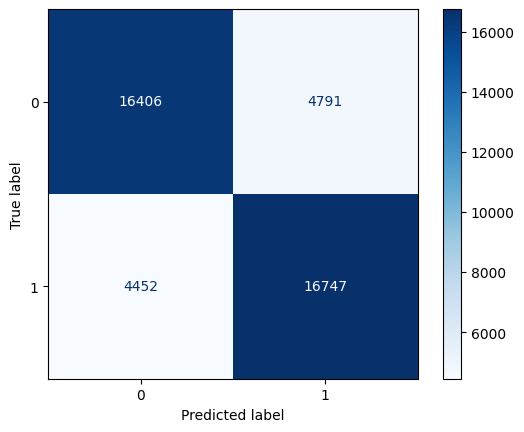

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_val, y_pred),
    display_labels=model.classes_
)
disp.plot(cmap="Blues")
plt.show()

#### Learning Curves & ROC Curve
Let's also extract the **learning curves** of the base model between the training and validating data, and the **ROC curve**.

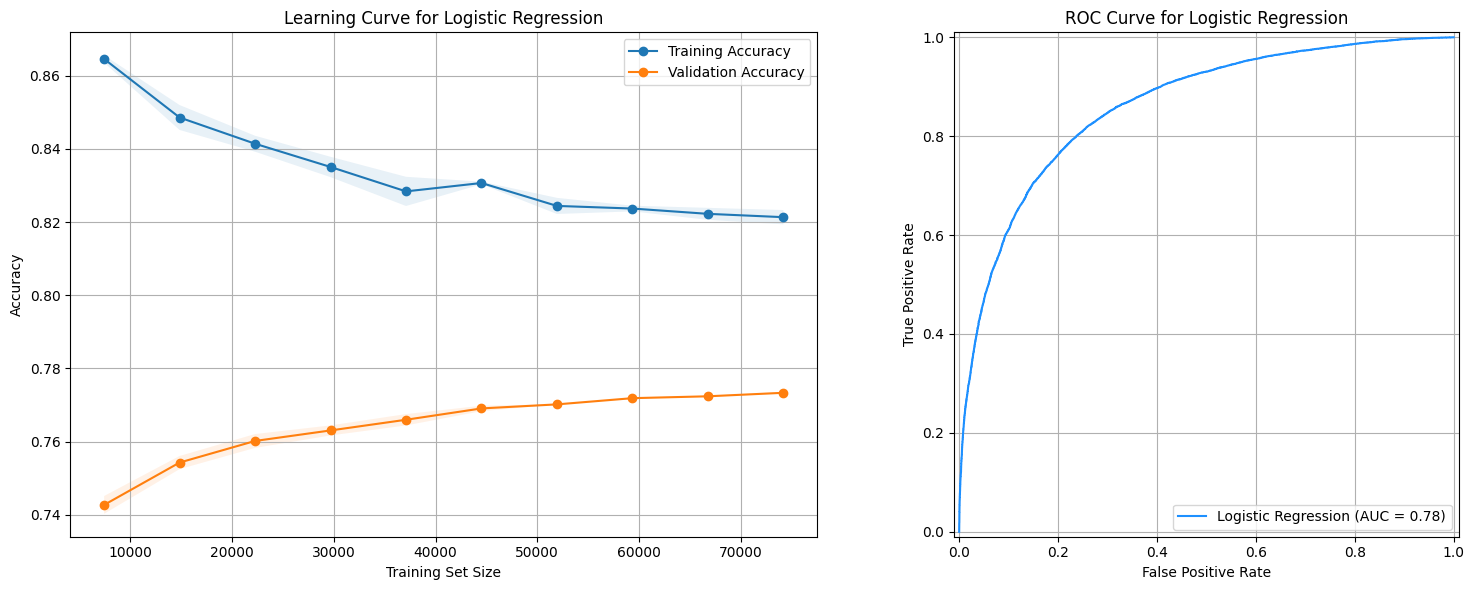

In [63]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, RocCurveDisplay

train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=2, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10)
)

# Compute mean and std deviation for shading
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(test_scores, axis=1)
val_std = np.std(test_scores, axis=1)

# Extract the ROC curve of the model
y_pred_proba = model.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)

# Plot learning curves and ROC curve side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Learning Curve
axes[0].plot(train_sizes, train_mean, 'o-', label="Training Accuracy")
axes[0].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
axes[0].plot(train_sizes, val_mean, 'o-', label="Validation Accuracy")
axes[0].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
axes[0].set_xlabel("Training Set Size")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Learning Curve for Logistic Regression")
axes[0].legend()
axes[0].grid()

# ROC Curve
roc_display = RocCurveDisplay(
    fpr=fpr, 
    tpr=tpr, 
    roc_auc=model.score(X_val, y_val), 
    estimator_name="Logistic Regression"
)
roc_display.plot(ax=axes[1], color='dodgerblue')
axes[1].set_title("ROC Curve for Logistic Regression")
axes[1].grid(True)

plt.tight_layout()
plt.show()


### PCA & SVD for Data Visualization

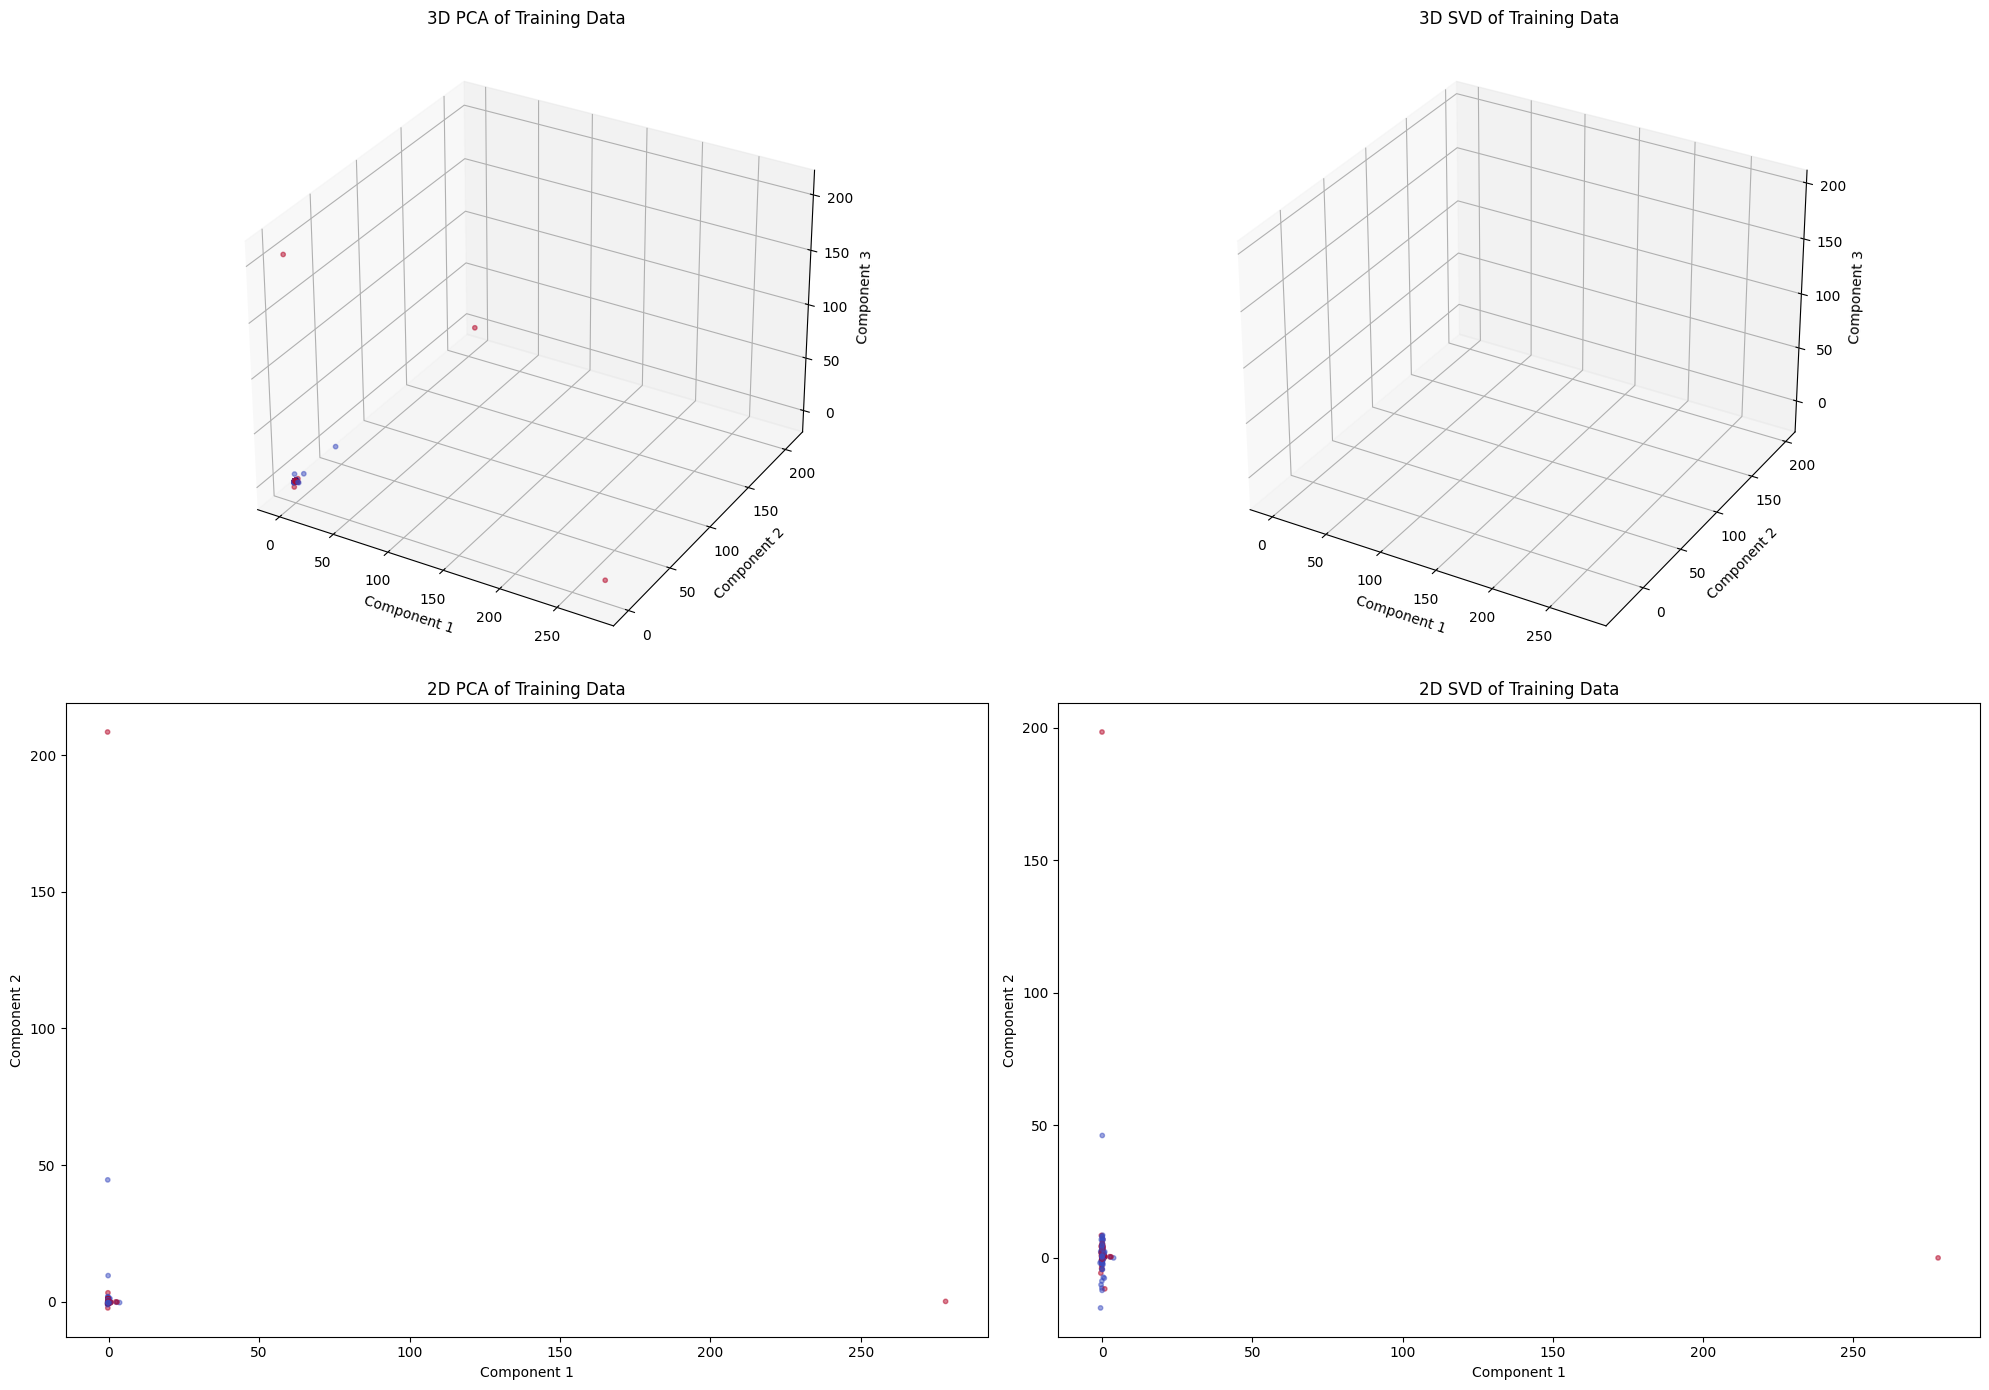

In [74]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_pca_svd(X_train, y_train, sample_size=2000):

  # Standardize the data
  scaler = StandardScaler(with_mean=False)  # with_mean=False to handle sparse matrix
  X_train_scaled = scaler.fit_transform(X_train[:sample_size])

  # Apply PCA
  pca_3d = PCA(n_components=3)
  X_train_pca_3d = pca_3d.fit_transform(X_train_scaled)

  pca_2d = PCA(n_components=2)
  X_train_pca_2d = pca_2d.fit_transform(X_train_scaled)

  # Apply SVD
  svd_3d = TruncatedSVD(n_components=3)
  X_train_svd_3d = svd_3d.fit_transform(X_train_scaled)

  svd_2d = TruncatedSVD(n_components=2)
  X_train_svd_2d = svd_2d.fit_transform(X_train_scaled)

  # Visualize the PCA and SVD results in 3D and 2D
  fig = plt.figure(figsize=(20, 14))

  # 3D PCA plot
  ax1 = fig.add_subplot(221, projection='3d')
  scatter1 = ax1.scatter(
      X_train_pca_3d[:, 0], X_train_pca_3d[:, 1], X_train_pca_3d[:, 2], 
      c=y_train[:sample_size], s=10, cmap='coolwarm', alpha=0.5
  )
  ax1.set_xlabel('Component 1')
  ax1.set_ylabel('Component 2')
  ax1.set_zlabel('Component 3')
  ax1.set_title('3D PCA of Training Data')

  # 3D SVD plot
  ax2 = fig.add_subplot(222, projection='3d')
  scatter2 = ax2.scatter(
      X_train_svd_3d[:, 0], X_train_svd_3d[:, 1], X_train_svd_3d[:, 2], 
      c=y_train[:sample_size], s=10, cmap='coolwarm', alpha=0.
  )
  ax2.set_xlabel('Component 1')
  ax2.set_ylabel('Component 2')
  ax2.set_zlabel('Component 3')
  ax2.set_title('3D SVD of Training Data')

  # 2D PCA plot
  ax3 = fig.add_subplot(223)
  scatter3 = ax3.scatter(
      X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], c=y_train[:sample_size], 
      s=10, cmap='coolwarm', alpha=0.5
  )
  ax3.set_xlabel('Component 1')
  ax3.set_ylabel('Component 2')
  ax3.set_title('2D PCA of Training Data')

  # 2D SVD plot
  ax4 = fig.add_subplot(224)
  scatter4 = ax4.scatter(
      X_train_svd_2d[:, 0], X_train_svd_2d[:, 1], c=y_train[:sample_size], 
      s=10, cmap='coolwarm', alpha=0.5
  )
  ax4.set_xlabel('Component 1')
  ax4.set_ylabel('Component 2')
  ax4.set_title('2D SVD of Training Data')

  plt.tight_layout()
  plt.show()

# Example usage
visualize_pca_svd(X_train, y_train)


In [64]:
# Load the data and vectorize them using TF-IDF method
X_train, X_val, X_test, y_train, y_val, vectorizer = vectorize_data(train_df, val_df, test_df, 85000, (1,4))
print(X_train.shape, X_val.shape)

(148388, 85000) (42396, 85000)


In [65]:
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

### Testing the model
After the **model training**, the next step is to **test** the model using the **validation data**. We will test the model and print the **accuracy** and the **classification report**.

In [66]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
print(f"Accuracy: {accuracy}\nClassification Report:\n{report}")

Accuracy: 0.7977403528634777
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80     21197
           1       0.79      0.80      0.80     21199

    accuracy                           0.80     42396
   macro avg       0.80      0.80      0.80     42396
weighted avg       0.80      0.80      0.80     42396



As we se, the accuracy of the model is **around 0.7650** and the **classification report** is being shown above. We can also plot the **confusion matrix** to take a better look at the results.

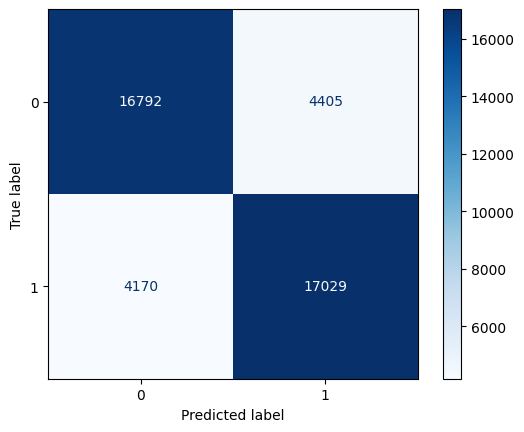

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_val, y_pred),
    display_labels=model.classes_
)
disp.plot(cmap="Blues")
plt.show()

The confusion matrix shows the results of the model prediction on the validation data and we observe that **most of the time** the predictions were **correct**. There are although some mistakes, such as that 4609 positive comment where predicted as negative and 5350 negative were predicted as positive. 

Let's also plot the learning curves of the model.

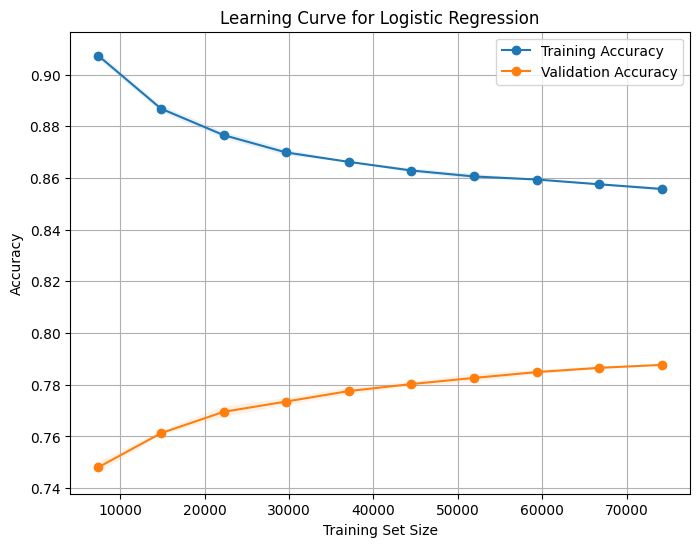

In [68]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=2, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10)
)

# Compute mean and std deviation for shading
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(test_scores, axis=1)
val_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Training Accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)

plt.plot(train_sizes, val_mean, 'o-', label="Validation Accuracy")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)

plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Logistic Regression")
plt.legend()
plt.grid()
plt.show()

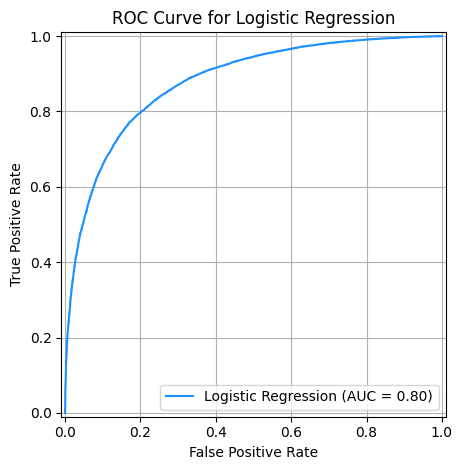

In [69]:
# Exctarct the ROC curve of the model
from sklearn.metrics import roc_curve, RocCurveDisplay

y_pred_proba = model.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)

roc_display = RocCurveDisplay(
  fpr=fpr, 
  tpr=tpr, 
  roc_auc=model.score(X_val, y_val),
  estimator_name="Logistic Regression",
)
roc_display.plot(color='dodgerblue')

plt.title("ROC Curve for Logistic Regression")
plt.grid(True)

plt.tight_layout()
plt.show()

In [70]:
y_pred = model.predict(X_test)

submission_df = pd.DataFrame({'ID': test_df['ID'], 'Label': y_pred})
submission_df.to_csv('submission.csv', index=False)
submission_df

,ID,Label
0,102388,1
1,153802,0
2,61831,0
3,18317,1
4,50061,1
...,...,...
21194,101544,0
21195,5461,0
21196,135996,1
21197,157554,1


In [71]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'lbfgs']
}

# Initialize the model
model = LogisticRegression()

# Initialize Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")

# Train the model with the best parameters
best_model = LogisticRegression(**best_params)
best_model.fit(X_train, y_train)

Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation Score: 0.7939927548850683


LogisticRegression(C=1, solver='liblinear')

In [72]:
# Evaluate the model
y_probs = best_model.predict_proba(X_val)[:, 1]
y_pred = (y_probs >= 0.5).astype(int)
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
print(f"Accuracy: {accuracy}\nClassification Report:\n{report}")

Accuracy: 0.7977403528634777
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80     21197
           1       0.79      0.80      0.80     21199

    accuracy                           0.80     42396
   macro avg       0.80      0.80      0.80     42396
weighted avg       0.80      0.80      0.80     42396



In [73]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))


Accuracy: 0.7977403528634777
Precision: 0.7944853970327517
Recall: 0.8032926081418935
F1 Score: 0.7988647292003846
